In [52]:
import numpy as np
from skimage import io
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.util import view_as_blocks
from skimage.morphology import disk, square
from skimage.filters import median, gaussian
from skimage.color import rgb2hsv, hsv2rgb
from skimage.exposure import equalize_adapthist
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.utils import shuffle

import os
from itertools import permutations
import matplotlib.pyplot as plt

In [2]:
convolutions = np.array([
    [[2, 2], [2, 2]],

    [[11, -1], [-1, -1]],
    [[-1, 11], [-1, -1]],
    [[-1, -1], [11, -1]],
    [[-1, -1], [-1, 11]],
      
    [[5, 5], [-1, -1]],
    [[-1, -1], [5, 5]],
    
    [[5, -1], [5, -1]],
    [[-1, 5], [-1, 5]],
    
    [[5, -1], [-1, 5]],
    [[-1, 5], [5, -1]],
    
    [[-1, 3], [3, 3]],
    [[3, -1], [3, 3]],
    [[3, 3], [-1, 3]],
    [[3, 3], [3, -1]]
], dtype="int")
solutions = np.array([
    [[1, 1], [1, 1]],
    
    [[0, 1], [1, 1]],
    [[1, 0], [1, 1]],
    [[1, 1], [0, 1]],
    [[1, 1], [1, 0]],
        
    [[1, 1], [0, 0]],
    [[0, 0], [1, 1]],
    
    [[1, 0], [1, 0]],
    [[0, 1], [0, 1]],
    
    [[1, 0], [1, 0]],
    [[0, 1], [0, 1]],
    
    [[1, 0], [0, 0]],
    [[0, 1], [0, 0]],
    [[0, 0], [1, 0]],
    [[0, 0], [0, 1]],
], dtype="bool")

In [53]:
def _pad(image):
    ''' Pad image to be size mod 4 '''
    h, w = np.mod(image.shape, 4)
    return np.pad(image, ((3 - h if h else 0, 1 if h else 0), (3 - w if w else 0, 1 if w else 0)), 'edge')

@adapt_rgb(each_channel)
def _reduce(image, n_iter=1, treshold=0):
    image = median(image, square(4))
    for _ in range(n_iter):
        image = _pad(image)
        h, w = image.shape
        h, w = h // 2, w // 2
        new_image = np.zeros((h * w)).astype("int")
        view = view_as_blocks(image, (2, 2))
        flatten = view.reshape(-1, 2, 2)
        for i, f in enumerate(flatten):
            conv = np.abs(np.sum(np.multiply(convolutions, f.reshape(-1, 2, 2)).reshape(-1, 4), axis=1))
            new_image[i] = np.mean(f[solutions[np.argmax(conv)]])
        new_image = new_image.reshape((h, w))    
        image = new_image.copy()
    return new_image

def pyxelate(image, n_colors=8, n_iter=1, random_state=0):
    image = equalize_adapthist(image) * 255 * 1.11
    examples = shuffle(image.reshape(-1, 3), random_state=random_state)[:4048]
     
    model = BayesianGaussianMixture(n_components=n_colors, max_iter=256, covariance_type="tied", random_state=random_state)
    model.fit(examples)
    
    image = _reduce(image, n_iter)
    width, height, depth = image.shape
    reshaped = np.reshape(image, (width * height, depth))
    y = model.predict(reshaped)
    palette = rgb2hsv(model.means_.reshape(-1, 1, 3))
    palette[:, :, 1] *= 1.11
    palette = hsv2rgb(palette).reshape(n_colors, 3) // 8 * 8
    
    image = np.reshape(palette[y], (width, height, depth))
    return np.clip(image.astype("int"), 0, 255)


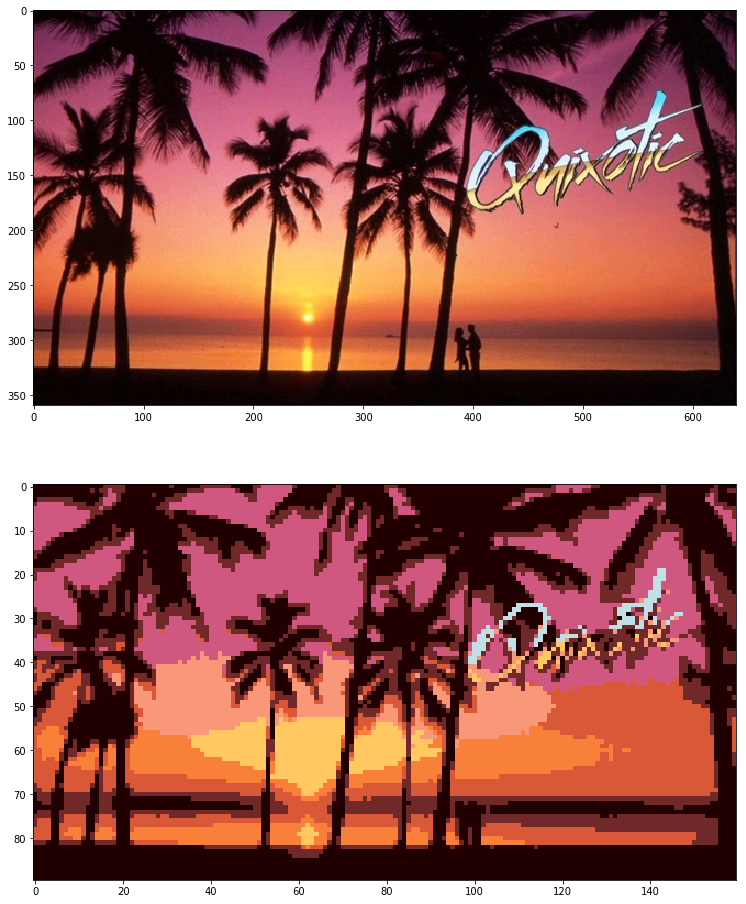

In [62]:
img = io.imread("q.jpg")
_, axes = plt.subplots(2, 1, figsize=(16, 16))
axes[0].imshow(img)
axes[1].imshow(pyxelate(img, 8, 2))

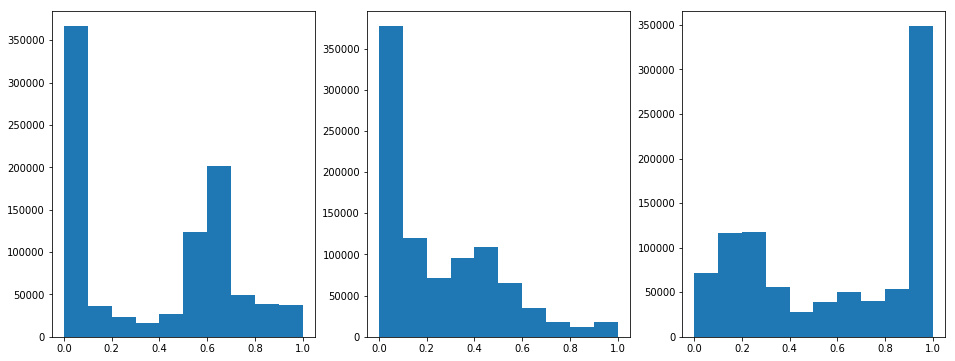

In [6]:
img = rgb2hsv(img)
_, axes = plt.subplots(1, 3, figsize=(16, 6))
for i in range(3):
    axes[i].hist(img[:, :, i].ravel(), color=[])

In [202]:
a = np.arange(0, 4*4).reshape(4, 4)
#print(a)
view = view_as_blocks(a, (2,2))
#print(view)
flatten = view.reshape(-1, 2, 2)
#print()
for f in flatten:
    print(f)
    print(np.sum(np.multiply(convolutions, f.reshape(-1, 2, 2)).reshape(-1, 4), axis=1))
    print(np.median(f[solutions[0]]))
    print()
#print(np.mean(flatten, axis=0))
    

[[0 1]
 [4 5]]
[-10  -8  -2   0  -8   8  -2   2   0   0  10   8   2   0]
4.0

[[2 3]
 [6 7]]
[-14 -12  -6  -4  -8   8  -2   2   0   0  14  12   6   4]
6.0

[[ 8  9]
 [12 13]]
[-26 -24 -18 -16  -8   8  -2   2   0   0  26  24  18  16]
12.0

[[10 11]
 [14 15]]
[-30 -28 -22 -20  -8   8  -2   2   0   0  30  28  22  20]
14.0



In [254]:
for r,g,b in zip(permutations([1, 0, 0]), permutations([0, 1, 0]), permutations([0, 0, 1])):
    print(np.array(r) + np.array(g) + np.array(b))

[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
[1 1 1]
